# Reflection with LangChain (Tweet Generator)

In [1]:
pip install --upgrade -q openai langchain langchain-openai langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


## Generate

In [2]:
# loading the API keys
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [4]:
# importing the necessary libraries
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

In [5]:
# creating a chat prompt template
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are a Twitter expert assigned to craft outstanding tweets.
            Generate the most engaging and impactful tweet possible based on the user's request.
            If the user provides feedback, refine and enhance your previous attempts accordingly for maximum engagement.''',
        ),
        MessagesPlaceholder(variable_name='messages'),
    ]
)

llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0.7)

# using LCEL to create the generate_chain
generate_chain  = generation_prompt | llm

In [6]:
generate_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="You are a Twitter expert assigned to craft outstanding tweets.\n            Generate the most engaging and impactful tweet possible based on the user's request.\n            If the user provides feedback, refine and enhance your previous attempts accordingly for maximum engagement.")), MessagesPlaceholder(variable_name='messages')])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x000001656B01BD70>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x000001656B0491F0>, model_name='gpt-4

In [6]:
tweet = ''
request = HumanMessage(
    content='FIFA World Cup 26'
)

for chunk in generate_chain.stream(
    {'messages': [request]}
): 
    print(chunk.content, end='')
    tweet += chunk.content

🌍⚽️ The countdown to FIFA World Cup 2026 has begun! 🏆 Get ready to unite under one banner as the world’s best teams battle it out across the USA, Canada, and Mexico! 🇺🇸🇨🇦🇲🇽 Who are you rooting for? Let the games begin! #FIFAWorldCup2026 #FootballFever #RoadTo2026

## Reflect and Repeat

In [7]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are a Twitter influencer known for your engaging content and sharp insights.
            Review and critique the user’s tweet.
            Provide constructive feedback, focusing on enhancing its depth, style, and overall impact.
            Offer specific suggestions to make the tweet more compelling and engaging for their audience.'''
        ),
        MessagesPlaceholder(variable_name='messages'),
    ]
)

reflect_chain  = reflection_prompt | llm

In [8]:
reflect_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a Twitter influencer known for your engaging content and sharp insights.\n            Review and critique the user’s tweet.\n            Provide constructive feedback, focusing on enhancing its depth, style, and overall impact.\n            Offer specific suggestions to make the tweet more compelling and engaging for their audience.')), MessagesPlaceholder(variable_name='messages')])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x0000026002FC8680>, async_client=<openai.resources.chat.completions.Async

In [9]:
reflection = ''
# streaming the response
for chunk in reflect_chain.stream(
    {'messages': [request, HumanMessage(content=tweet)]}
):
    print(chunk.content, end='')
    reflection += chunk.content


Your tweet does a great job of capturing the excitement surrounding the FIFA World Cup 2026! The use of emojis adds a fun visual element, and your enthusiasm is infectious. However, to enhance its depth and overall impact, consider the following suggestions:

1. **Add a Unique Insight or Statistic**: Mentioning something specific about the World Cup, like its historical significance or a fun fact (e.g., "This will be the first time the tournament is hosted by three countries!") can provide depth and make your tweet stand out.

2. **Engage with a Question**: Instead of a general "Who are you rooting for?" consider asking a more specific question that encourages discussion, like "Which team do you think will surprise us this year?" or "What is your favorite World Cup memory?" This invites more interaction from your audience.

3. **Personal Touch**: Share your own team preference or a personal anecdote related to the World Cup. For example, "As a lifelong fan of [your favorite team], I ca

In [10]:
for chunk in generate_chain.stream(
    {'messages': [request, AIMessage(content=tweet), HumanMessage(content=reflection)]}
):
    print(chunk.content, end='')

🌍⚽️ The countdown to FIFA World Cup 2026 has officially begun! 🏆 Did you know this will be the first time the tournament is hosted by three countries: the USA, Canada, and Mexico? 🇺🇸🇨🇦🇲🇽 As a lifelong fan of [your favorite team], I can’t wait to see them shine on this grand stage! ✨ Which team do you think will surprise us this year? Drop your predictions below! 🗳️ #FIFAWorldCup2026 #FootballFever #RoadTo2026

## Define the Graph

In [8]:
from typing import List, Sequence
from langgraph.graph import END, MessageGraph

In [9]:
# defining a function for the generation node
def generation_node(state: Sequence[BaseMessage]):
    return generate_chain.invoke({'messages': state})

# defining a function for the reflection node
def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # messages we need to adjust
    cls_map = {'ai': HumanMessage, 'human': AIMessage}
    # First message is the original user request. We keep it the same for all nodes
    translated = [messages[0]] + [
    cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = reflect_chain.invoke({'messages': translated})
    # We treat the output (AI message) of this as human feedback for the generator
    return HumanMessage(content=res.content)

# initializing the MessageGraph and adding two nodes to the graph: generate and reflect.
builder = MessageGraph()
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)

# setting the generate node as the starting point
builder.set_entry_point('generate')

MAX_ITERATIONS = 5
def should_continue(state: List[BaseMessage]):
    if len(state) > MAX_ITERATIONS:
        return END
    return 'reflect'

# adding a conditional edge to the graph
builder.add_conditional_edges('generate', should_continue)
builder.add_edge('reflect', 'generate')

# compiling the graph
graph = builder.compile()

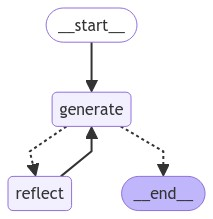

In [13]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Running the App

In [10]:
inputs = HumanMessage(content='Generate a tweed about FIFA World Cup 26')
response = graph.invoke(inputs)

In [11]:
for resp in response:
    print(resp.content)
    print('\n' + '-' * 100 + '\n')

Generate a tweed about FIFA World Cup 26

----------------------------------------------------------------------------------------------------

🌍⚽️ Excitement is building for #FIFAWorldCup2026! 🏆 With matches spanning across the USA, Canada, and Mexico, it’s a historic celebration of soccer! 🇺🇸🇨🇦🇲🇽 Who are you rooting for? Let’s kick off the countdown and unite as one global fanbase! 🌟 #WorldCup2026 #SoccerUnites

----------------------------------------------------------------------------------------------------

This tweet captures the excitement surrounding the FIFA World Cup 2026 well, but there are ways to enhance its depth, style, and overall impact. Here’s a critique and some suggestions for improvement:

### Critique:
1. **Depth**: The tweet could benefit from including more specifics about what makes this World Cup historic, such as the inclusion of more teams or the significance of it being held in three countries.
   
2. **Engagement**: While asking who the audience is rooti

In [1]:
pip install -q langsmith

Note: you may need to restart the kernel to use updated packages.
